In [1]:
""" use smaller learning rate for gradient descent or increase batch size """

import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import time 
import numpy as np
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
tf.compat.v1.disable_eager_execution() 
import tensorflow_probability as tfp
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import matplotlib.pyplot as plt

from data_loader import load_data
from data_preprocesser import preprocess_data
from maf import IAF 
from experiment import Experiment

Data successfully loaded...

Data successfully preprocessed...

TensorFlow version: 2.5.0
Number of dimensions: 37
Learning rate: 0.0001

Successfully created model...

Optimizer: Adam_3
Optimizer and loss successfully defined...

Iteration 0: 50.369712829589844
Iteration 10000: 32.351539611816406
Iteration 20000: 17.740650177001953
Iteration 30000: 12.172065734863281
Iteration 40000: 6.884134292602539
Iteration 50000: 5.102060317993164
Iteration 60000: 13.439035415649414
Iteration 70000: 6.604188919067383
Iteration 80000: 9.367420196533203
Iteration 90000: 8.510138511657715

Training completed...
Training time: 1309.3112959861755 seconds
Training finished...

Displaying results...


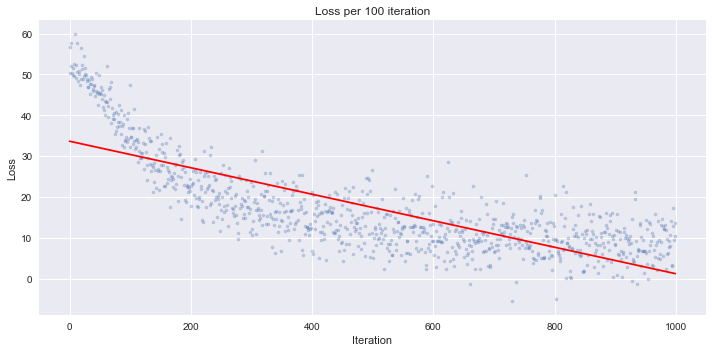

Optimizer: RMSProp
Optimizer and loss successfully defined...

Iteration 0: 50.369712829589844
Iteration 10000: 33.577423095703125
Iteration 20000: 20.499204635620117
Iteration 30000: 14.274614334106445
Iteration 40000: 9.26140308380127
Iteration 50000: 7.128457069396973
Iteration 60000: 15.631103515625
Iteration 70000: 8.454219818115234
Iteration 80000: 14.410531997680664
Iteration 90000: 10.222795486450195

Training completed...
Training time: 1514.8063879013062 seconds
Training finished...

Displaying results...


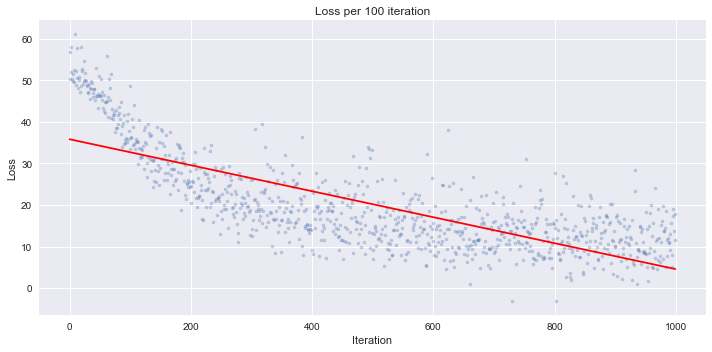

Optimizer: GradientDescent
Optimizer and loss successfully defined...

Iteration 0: 50.369712829589844
Iteration 10000: 46.619720458984375
Iteration 20000: 38.598575592041016
Iteration 30000: 32.293174743652344
Iteration 40000: 28.170124053955078
Iteration 50000: 26.723487854003906
Iteration 60000: 27.807218551635742
Iteration 70000: 23.585201263427734
Iteration 80000: 24.648847579956055
Iteration 90000: 22.16717529296875

Training completed...
Training time: 1411.0591659545898 seconds
Training finished...

Displaying results...


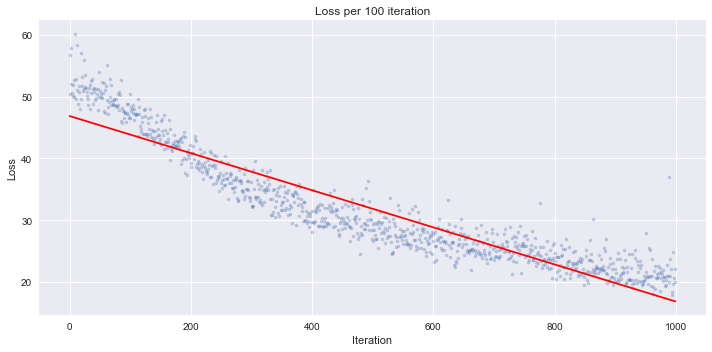

In [6]:
def train(session, loss, optimizer, steps=int(1e5)):
    
    """ optimize for all dimensions """
    
    start_time = time.time()
    
    recorded_steps = []
    recorded_losses = []
    for i in range(steps):
        _, loss_per_iteration = session.run([optimizer, loss])
        if i % 100 == 0:
            recorded_steps.append(i)
            recorded_losses.append(loss_per_iteration)
        if i % int(1e4) == 0:
            print('Iteration {iteration}: {loss}'.format(iteration=i,loss=loss_per_iteration))
    print('\nTraining completed...')
    print(f'Training time: {time.time() - start_time} seconds')
    return recorded_losses


def plot_results(recorded_losses):
    
    """ plot loss """
    print('Displaying results...')
    fig = plt.figure(figsize=(10,5))
    x = np.arange(len(recorded_losses))
    y = recorded_losses
    m, b = np.polyfit(x, y, 1) 
    plt.scatter(x, y, s=10, alpha=0.3)
    plt.plot(x, m*x+b, c="r")
    plt.title('Loss per 100 iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

def main():
    
    """ load data """

    filename = 'prostate.xls'
    directory = '/Users/kaanguney.keklikci/Data/'

    loader = load_data(filename, directory)
    loader.create_directory(directory)
    data = loader.read_data(directory, filename)
    print('Data successfully loaded...\n')
    
    """ preprocess data """

    fillna_vals = ['sz', 'sg', 'wt']
    dropna_vals = ['ekg', 'age']
    drop_vals = ['patno', 'sdate']

    preprocesser = preprocess_data(StandardScaler(), fillna_vals, dropna_vals, drop_vals)
    data = preprocesser.dropna_features(data)
    data = preprocesser.impute(data)
    data = preprocesser.drop_features(data)
    data = preprocesser.encode_categorical(data)
    data = preprocesser.scale(data)
    print('Data successfully preprocessed...\n')
    
    """ set IAF parameters """

    batch_size = 32
    dtype = np.float32
    tf_version = tf.__version__
    params = 2
    hidden_units = [5,5] # set this to a small number if you are using CPU
    base_dist = tfp.distributions.Normal(loc=0., scale=1., name="gaussian")
    dims = data.shape[1]
    learning_rate = 1e-4
    steps = 1e4
    activation = 'relu'
    hidden_degrees = 'random'
    conditional=True
    conditional_event_shape = (dims,)
    event_shape = conditional_event_shape
    conditional_input_layers = 'first_layer'
    
    """ initialize samples """

    iaf = IAF(dtype, tf_version, batch_size, 
              params, hidden_units, base_dist, dims,
              activation,
              conditional, hidden_degrees, 
              conditional_event_shape,
              conditional_input_layers,
              event_shape
             )

    dims = iaf.get_dims(data)
    samples = iaf.create_tensor(data)
    print(f'TensorFlow version: {iaf.tf_version}')
    print(f'Number of dimensions: {iaf.dims}')
    print(f'Learning rate: {learning_rate}\n')
    
    """ initialize IAF """

    iaf = iaf.make_maf(data)
    print('Successfully created model...\n')
    
    """ initialize loss and optimizer """

    loss = -tf.reduce_mean(iaf.log_prob(samples, bijector_kwargs={'conditional_input': samples}))    
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss)
    
    experiment = Experiment(optimizer, learning_rate, loss, steps)
    
    keywords = ['adam', 'rmsprop', 'sgd']
    
    for keyword in keywords:
    
        session = tf.compat.v1.Session()
        tf.compat.v1.set_random_seed(42)
        experiment.change_optimizer(learning_rate, loss, keyword=keyword)
        optimizer = experiment.get_optimizer()
        session.run(tf.compat.v1.global_variables_initializer())
        print(f'Optimizer: {optimizer.name}')
        print('Optimizer and loss successfully defined...\n')

        """ start training """
        recorded_losses = train(session, loss, optimizer)
        print('Training finished...\n')

        """ display results """
        plot_results(recorded_losses)
    
    
if __name__ == "__main__":
    main()